In [179]:
import pandas as pd
import numpy as np
import jieba
import os
import seaborn as sns

rather than using built in dict from existing libraries, use external sentiment dictionary. Unit of analysis is version.

In [19]:
sentment_table = pd.read_excel('情感词典修改版.xlsx')
sentment_table.drop(['Unnamed: 10','Unnamed: 11'],inplace=True,axis=1)
pos_table = pd.read_excel('情感词典修改版.xlsx',sheet_name='Sheet2', header=None)
neg_table = pd.read_excel('情感词典修改版.xlsx',sheet_name='Sheet3', header=None)

In [10]:
pos_table.columns = ['posword', 'score']
neg_table.columns = ['negword', 'score']
pos_dict = dict(zip(list(pos_table.posword),list(pos_table.score)))
neg_dict = dict(zip(list(neg_table.negword),map(lambda a:a*(0-1),list(neg_table.score)) ))
sentment_dict={**pos_dict,**neg_dict}

In [13]:
for w in sentment_dict.keys():
    jieba.suggest_freq(w,True)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/24/_5wy0sws5fb4gqxn_rjr22cm0000gn/T/jieba.cache
Loading model cost 0.879 seconds.
Prefix dict has been built successfully.


In [221]:
path = "/Users/onyilam/Dropbox/history_textbooks_txt"

# read files by origin as  and split them into sentences

corpus = pd.DataFrame()
for file in os.listdir(path):
    for val in ['tw_', 'ma_', 'hk_']:
        if file.startswith(val):
            print(file)
            with open(os.path.join(path, file), 'r') as f:
                text = f.read()
                text = text.replace('\r', '').replace('\n', '').replace('\t', '')
                #indivStr = re.split('。|？|:', text)
                indivStr = re.split('---------', text)
                df = pd.DataFrame(indivStr)
                df['origin'] = val[:-1]
                df['book'] = file
                corpus = corpus.append(df)
                
                

ma_人民版高中历史必修一现代中国部分.txt
tw_龙腾.txt
ma_人民版高中历史必修二现代中国部分.txt
tw_南一第二.txt
ma_人教版高中历史必修二现代中国部分.txt
ma_人教版高中历史必修一现代中国部分.txt
ma_岳麓版高中历史必修三现代中国部分.txt
hk_現代5上.txt
hk_現代5下.txt
tw_康熹.txt
hk_現代4下.txt
hk_文達必修6.txt
ma_人民版高中历史必修三现代中国部分.txt
hk_文達必修5.txt
hk_文達必修4.txt
ma_岳麓版高中历史必修一现代中国部分.txt
ma_人教版高中历史必修三现代中国部分.txt
ma_岳麓版高中历史必修二现代中国部分.txt


In [222]:
corpus.columns = ['sentence', 'origin', 'book']
#remove empty rows
corpus = corpus[corpus['sentence']!=""]
# dummify the origin variable
corpus = pd.concat( [corpus, pd.get_dummies(corpus['origin'])], axis = 1)


In [223]:
corpus['version'] = corpus['book'].str[:5]

In [224]:
def sent2word(sentence):
    words = jieba.cut(sentence, HMM=False)
    #words = [w for w in words if w not in stop_words]
    return words

In [225]:
def get_sentment(sent):
    tokens = sent2word(sent)
    score = 0
    countword = 0
    for w in tokens:
        
        if w in sentment_dict.keys():
            score += sentment_dict[w]
            countword += 1
    if countword != 0:
        return score/countword
    else:
        return 0

In [226]:
def get_feature(sent):
    tokens = sent2word(sent)
    feature_list = []
    for w in tokens:
        
        if w in sentment_dict.keys():
            feature_list.append( (w, sentment_dict[w]))
            
    
    return feature_list
    

In [227]:
# group by version, and calculate the aggregate sentiment
corpus = corpus.groupby(['version'])['sentence'].apply(','.join).reset_index()
corpus['sentiment'] = corpus['sentence'].apply(lambda x: get_sentment(x))

In [228]:
corpus['feature_list'] = corpus['sentence'].apply(lambda x: get_feature(x))
corpus['origin'] = corpus['version'].str[:2]

In [229]:
corpus.sort_values('sentiment')

,version,sentence,sentiment,feature_list,origin
0,hk_文達,第一节 建国初期巩固政权的措施中华人民共和国成立後面对着不少困难为了稳定局势及恢复经济中央政...,-0.004450,"[(恢复, 1), (反革命, -5), (地主, -3), (剥削, -3), (支持, ...",hk
1,hk_現代,课题一民初政局第一章袁世凯的帝制运动 中华民国成立後中央政府的权力落在袁世凯手上他曾压革命党...,0.113703,"[(恢复, 1), (民主, 3), (摧残, -5), (推荐, 7), (革命, 3),...",hk
6,tw_康熹,﻿第四篇 近代的冲击（晚清）第九章 敌国的倾颓第一节 西力冲击与西风东渐单口通商下的中外关系...,0.618774,"[(敌国, -1), (无知, -7), (自诩, -5), (才能, 5), (朝贡, 5...",tw
5,tw_南一,P.118清朝晚期，可説是内外交迫。除遭受列强不断侵略外外，从十九世纪中叶起的二十馀年间，内...,0.851506,"[(列强, -7), (侵略, -3), (动乱, -7), (频仍, -3), (散兵游勇...",tw
7,tw_龙腾,第四篇 近代的冲击至晚清第九章 敌国的倾颓第一节 内部动乱与地方势力的崛起一、白莲教之乱社会...,0.961128,"[(敌国, -1), (动乱, -7), (茂密, 3), (活跃, 5), (败坏, -5...",tw
3,ma_人民,从1840年开始，为打开中国的大门，列强凭借强大的经济实力和船坚炮利的军事优势，屡屡对中国发...,1.459016,"[(列强, -7), (强大, 5), (侵略战争, -7), (不平等条约, -7), (...",ma
2,ma_人教,第三单元 近代中国经济结构的变动与资本主义的曲折发展鸦片战争以后，西方列强的经济侵略，摧毁了...,1.574638,"[(变动, -5), (列强, -7), (摧毁, -7), (瓦解, -5), (封建, ...",ma
4,ma_岳麓,﻿第五单元 近现代中国的先进思想第二十课 西学东渐开眼看世界鸦片战争前后，外国资本主义对中国...,1.799840,"[(先进, 5), (抵御, 3), (侵略, -3), (热忱, 5), (先进, 5),...",ma


In [230]:
len(corpus)

8

In [231]:
corpus.groupby(['origin'])['sentiment'].mean()

origin
hk    0.054626
ma    1.611165
tw    0.810469
Name: sentiment, dtype: float64

In [233]:
def char_count(sent):
    #remove punctuation
    punc = "！？｡。＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏."
    sent = re.sub(r"[%s]+" %punc, "", sent)
    return len(sent)

In [234]:
corpus['num_char'] = corpus['sentence'].apply(lambda x: char_count(x))

In [235]:
corpus.groupby(['origin'])['num_char'].mean()

origin
hk    84012.500000
ma    47510.666667
tw    36299.666667
Name: num_char, dtype: float64

In [153]:
corpus.groupby(['origin'])['num_char'].std()

origin
hk    5142.731910
ma    6037.786966
tw    4689.266929
Name: num_char, dtype: float64

In [154]:
corpus.groupby(['origin'])['num_char'].median()

origin
hk    28839.5
ma    12031.0
tw    34112.0
Name: num_char, dtype: float64

### Pre and Post 1949

In [236]:
path = "/Users/onyilam/Dropbox/history_textbooks_txt/Events/Post1949"

# read files by origin as  and split them into sentences

corpus49 = pd.DataFrame()
for file in os.listdir(path):
    for val in ['tw_', 'ma_', 'hk_']:
        if file.startswith(val) and 'old' not in file and 'all3' not in file: #excludes all3 from the filename
            print(file)
            with open(os.path.join(path, file), 'r') as f:
                text = f.read()
                text = text.replace('\r', '').replace('\n', '').replace('\t', '')
                #indivStr = re.split('。|？|:', text)
                indivStr = re.split('---------', text)
                df = pd.DataFrame(indivStr)
                df['origin'] = val[:-1]
                df['book'] = file
                if 'pre' in file:
                    df['period'] = 'pre'
                else:
                    df['period']='post'
                corpus49 = corpus49.append(df)
                
                

tw_龙腾pre1949.txt
ma_岳麓版pre1949.txt
hk_現代pre1949.txt
tw_南一post1949.txt
ma_岳麓版高中历史必修一post1949.txt
tw_康熹post1949.txt
ma_人民版pre1949.txt
ma_人民版高中历史必修post1949.txt
ma_人教版高中历史必修一post1949.txt
tw_康熹pre1949.txt
hk_文達post1949.txt
ma_人教版pre1949.txt
hk_文達pre1949.txt
hk_現代post1949.txt
tw_南一pre1949.txt
tw_龙腾post1949.txt


In [237]:
len(corpus49)

16

In [238]:
corpus49.columns = ['sentence', 'origin', 'book', 'period']
#remove empty rows
corpus49 = corpus49[corpus49['sentence']!=""]
# dummify the origin variable
corpus49 = pd.concat( [corpus49, pd.get_dummies(corpus49['origin'])], axis = 1)
corpus49['sentiment'] = corpus49['sentence'].apply(lambda x: get_sentment(x))

In [239]:
corpus49.sort_values('sentiment')

,sentence,origin,book,period,hk,ma,tw,sentiment
0,从1840年开始，为打开中国的大门，列强凭借强大的经济实力和船坚炮利的军事优势，屡屡对中国发...,ma,ma_人民版pre1949.txt,pre,0,1,0,-0.650672
0,第四单元 内忧外患与中华民族的奋起当欧洲、北美资本主义制度确立之时，中国延续了2000多年的...,ma,ma_岳麓版pre1949.txt,pre,0,1,0,-0.371345
0,课题一 列强的入侵第一章中英鸦片战争乾隆晚年清朝隔世油性转衰嘉庆道光以来政治腐败经济凋敝社会...,hk,hk_現代pre1949.txt,pre,1,0,0,-0.277244
0,清朝统治前期曾出现了康雍乾盛世但到了乾隆晚年国力逐渐衰弱而此时的欧洲国家正迅速崛起进而觊觎中...,hk,hk_文達pre1949.txt,pre,1,0,0,-0.272274
0,第四单元 近代中国反侵略、求民主的潮流17世纪40年代，有两件大事在世界的东方和西方几乎同时...,ma,ma_人教版pre1949.txt,pre,0,1,0,0.029613
0,第二节 中华人民共和国的初期发展中共在国共内战获胜的原因在短短的4年内战之中，大陆竟然易手于...,tw,tw_康熹post1949.txt,post,0,0,1,0.398577
0,第一节 建国初期巩固政权的措施中华人民共和国成立後面对着不少困难为了稳定局势及恢复经济中央政...,hk,hk_文達post1949.txt,post,1,0,0,0.447212
0,P.199建国初期的统治（一）一党专政中华人民公和国成立之初，标榜人民民主专政，也容纳非共党...,tw,tw_南一post1949.txt,post,0,0,1,0.534884
0,第四篇 近代的冲击（晚清）第九章 敌国的倾颓第一节 西力冲击与西风东渐单口通商下的中外关系1...,tw,tw_康熹pre1949.txt,pre,0,0,1,0.699869
0,课题一社会主义建设建国初期的政治运动及经济措施（1949-1952）中华人民共和国成立初期国...,hk,hk_現代post1949.txt,post,1,0,0,0.825283


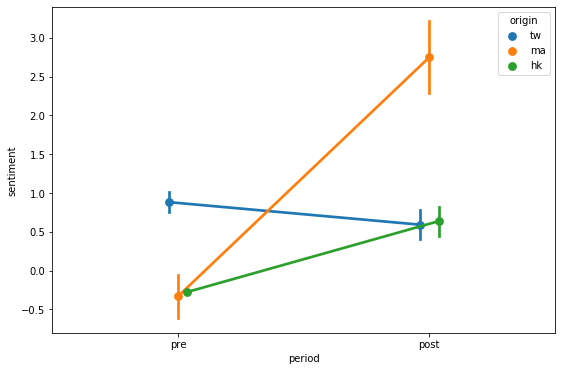

In [241]:
# the vertical bars show the standard deviation

a4_dims = (9, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.pointplot(ax = ax, x="period", y="sentiment", hue="origin", ci='sd',
                   data=corpus49, dodge=True)
